In [16]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt
import cv2
import xraylib
import random
import scipy.ndimage as ndimage
import tifffile

PLANCK_CONSTANT = 4.135667696e-18  # [keV*s]
SPEED_OF_LIGHT = 299792458  # [m/s]

%matplotlib inline

# Init data sizes and parametes of the PXM of ID16A

In [17]:
n = 1024  # object size in each dimension
ntheta = 4  # number of angles (rotations)

pn = 64  # tomography chunk size for GPU processing
ptheta = 4  # holography chunk size for GPU processing

center = n/2  # rotation axis
theta = np.linspace(0, np.pi, ntheta).astype('float32')  # projection angles

# ID16a setup
voxelsize = 10e-9*2048/n  # object voxel size
energy = 17.05  # [keV] xray energy
wavelength = PLANCK_CONSTANT * SPEED_OF_LIGHT / energy
focusToDetectorDistance = 1.28
ndist = 4
sx0 = 3.7e-4
# z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:ndist]-sx0
z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:ndist]-sx0
z1[:] = z1[0]
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = 270e-3# positions of the probe and code for reconstruction
z2p = z1-z1p
# magnification when propagating from the probe plane to the detector
magnificationsp = z1/z1p
# propagation distances after switching from the point source wave to plane wave,
distancesp = (z1p*z2p)/z1

norm_magnificationsp = magnificationsp/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distancesp = distancesp*norm_magnificationsp**2
distancesp = distancesp*(z1p/z1)**2

print(distances, distancesp)
print(distances+ distancesp)


[0.00420013 0.00420013 0.00420013 0.00420013] [-0.00414823 -0.00414823 -0.00414823 -0.00414823]
[5.18963367e-05 5.18963367e-05 5.18963367e-05 5.18963367e-05]


## Form a siemens star

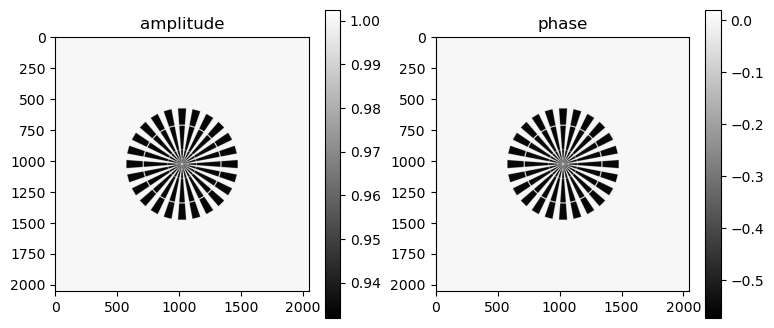

In [28]:
img = np.zeros((n, n, 3), np.uint8)
triangle = np.array([(n//16, n//2-n//32), (n//16, n//2+n//32), (n//2-n//128, n//2)], np.float32)
star = img[:,:,0]*0
for i in range(0, 360, 15):
    img = np.zeros((n, n, 3), np.uint8)
    degree = i
    theta = degree * np.pi / 180
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta), np.cos(theta)]], np.float32)    
    rotated = cv2.gemm(triangle-n//2, rot_mat, 1, None, 1, flags=cv2.GEMM_2_T)+n//2
    cv2.fillPoly(img, [np.int32(rotated)], (255, 0, 0))
    star+=img[:,:,0]
[x,y] = np.meshgrid(np.arange(-n//2,n//2),np.arange(-n//2,n//2))
x = x/n*2
y = y/n*2
# add holes in triangles
circ = (x**2+y**2>0.385)+(x**2+y**2<0.365)
circ *= (x**2+y**2>0.053)+(x**2+y**2<0.05)
circ *= (x**2+y**2>0.0085)+(x**2+y**2<0.008)
star = star*circ/255

v = np.arange(-n//2,n//2)/n
[vx,vy] = np.meshgrid(v,v)
v = np.exp(-5*(vx**2+vy**2))
fu = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(star)))
star = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fu*v))).real

delta = 1-xraylib.Refractive_Index_Re('Au',energy,19.3)
beta = xraylib.Refractive_Index_Im('Au',energy,19.3)

thickness = 600e-9/voxelsize # siemens star thickness in pixels
# form Transmittance function
u = star*(-delta+1j*beta) # note -delta
Ru = u*thickness 
psi = np.exp(1j * Ru * voxelsize * 2 * np.pi / wavelength)[np.newaxis].astype('complex64')
psi = np.pad(psi,((0,0),(n//2,n//2),(n//2,n//2)),'constant',constant_values=1)
psi = np.tile(psi,(ntheta,1,1))
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(psi[0]),cmap='gray')
axs[0].set_title('amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psi[0]),cmap='gray')
axs[1].set_title('phase')
fig.colorbar(im)

0.015607407407407408
52
[0.00420013 0.00420013 0.00420013 0.00420013] [-0.00414823 -0.00414823 -0.00414823 -0.00414823]


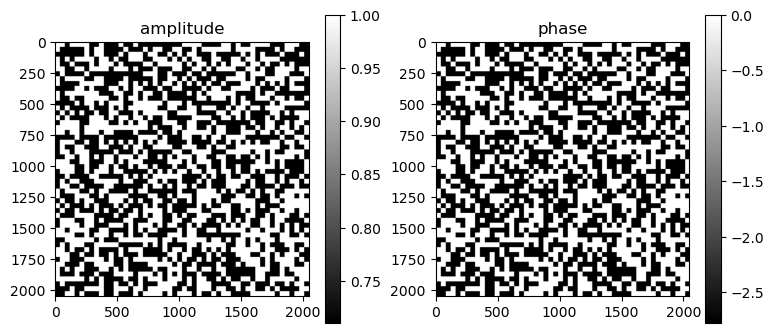

In [19]:
# make some large global code first
random.seed(10)
nill = 2**12
ill_global = np.zeros([1,nill,nill],dtype='bool')
for k in  range(ill_global.shape[0]):
    ill0 = np.zeros([nill*nill],dtype='bool')
    ill_ids = random.sample(range(0, nill*nill), nill*nill//2)
    ill0[ill_ids] = 1
    ill_global[k] = ill0.reshape(nill,nill)

# form codes for simulations
ill_feature_size = 5e-5
print(magnificationsp[0])
nill = int(2*n*voxelsize/magnificationsp[0]//(ill_feature_size*2))*2
print(nill)
ill = np.zeros([1,nill,nill],dtype='bool')
for k in  range(ill.shape[0]):
    ill0 = ill_global[k]
    ill[k] = ill0[ill0.shape[0]//2-nill//2:ill0.shape[0]//2+(nill)//2,ill0.shape[1]//2-nill//2:ill0.shape[1]//2+(nill)//2]#.reshape(nill,nill)
ill = ndimage.zoom(ill,[1,2*n/nill,2*n/nill],order=0,grid_mode=True,mode='grid-wrap')

delta = 1-xraylib.Refractive_Index_Re('Au',energy,19.3)
beta = xraylib.Refractive_Index_Im('Au',energy,19.3)

thickness = 3*1e-6/voxelsize # thickness in pixels

# form Transmittance function
Rill = ill*(-delta+1j*beta)*thickness 
psiill = np.exp(1j * Rill * voxelsize * 2 * np.pi / wavelength).astype('complex64')
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(psiill[0]),cmap='gray')
axs[0].set_title('amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psiill[0]),cmap='gray')
axs[1].set_title('phase')
fig.colorbar(im)
print(distances,distancesp)



## Form tranmistance function for the code made of gold with 1um feature size, and 3um thickness

In [20]:
shifts_code = (np.random.random([ndist, ntheta, 2]).astype('float32')-0.5)*n/8

## Read one probe

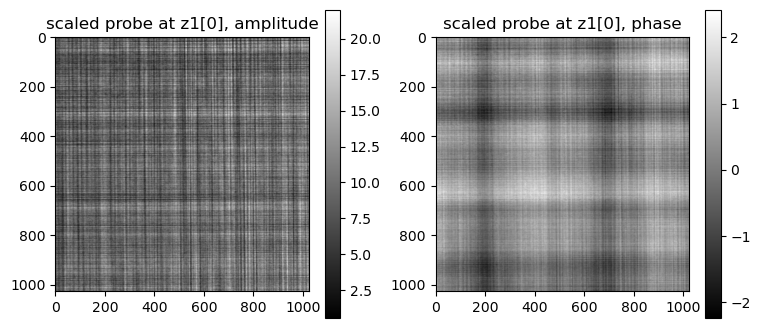

In [21]:
prb_abs = dxchange.read_tiff(f'data/prb_id16a/prb_abs_{n}.tiff')[0:ndist]
prb_phase = dxchange.read_tiff(f'data/prb_id16a/prb_phase_{n}.tiff')[0:ndist]
prb = prb_abs*np.exp(1j*prb_phase).astype('complex64')  
prb[:] = prb[0]

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(prb[0]),cmap='gray')
axs[0].set_title('scaled probe at z1[0], amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(prb[0]),cmap='gray')
axs[1].set_title('scaled probe at z1[0], phase')
fig.colorbar(im)


## Create a solver class for holography, note the class has additional parameters distancesp to be able to compute Fresnel propagation between the sample and probe

In [22]:
pslv = holotomo.SolverHolo(ntheta, n, ptheta, voxelsize, energy, distances, norm_magnifications, distancesp)

## Model data

In [29]:
shifts = (np.random.random([ndist, ntheta, 2]).astype('float32')-0.5)*n/16*0#*norm_magnifications[:,np.newaxis,np.newaxis]
shifts_ref = shifts/norm_magnifications[:,np.newaxis,np.newaxis]
fpsi = pslv.fwd_holo_batch(psi,prb,shifts_ref,psiill,shifts_code)
fpsi0 = pslv.fwd_holo_batch(psi,prb*0+1,shifts_ref,psiill,shifts_code) # ignore probe

pslv0 = holotomo.SolverHolo(1, n, 1, voxelsize, energy, distances[:1], norm_magnifications[:1], distancesp[:1]) 
fref = pslv0.fwd_holo_batch(psi*0+1,prb,shifts_ref[:1,:1]*0,psiill,shifts_code[:1,:1]*0) # ignore sample

(1, 2048, 2048) (4, 4, 2)


## Take squared absolute value to simulate data on the detector, flat fields, and data with homogeneous flat fields  

In [30]:
data = np.abs(fpsi)**2
data_ref = np.abs(fref)**2

## Show data and flat fields for different codes

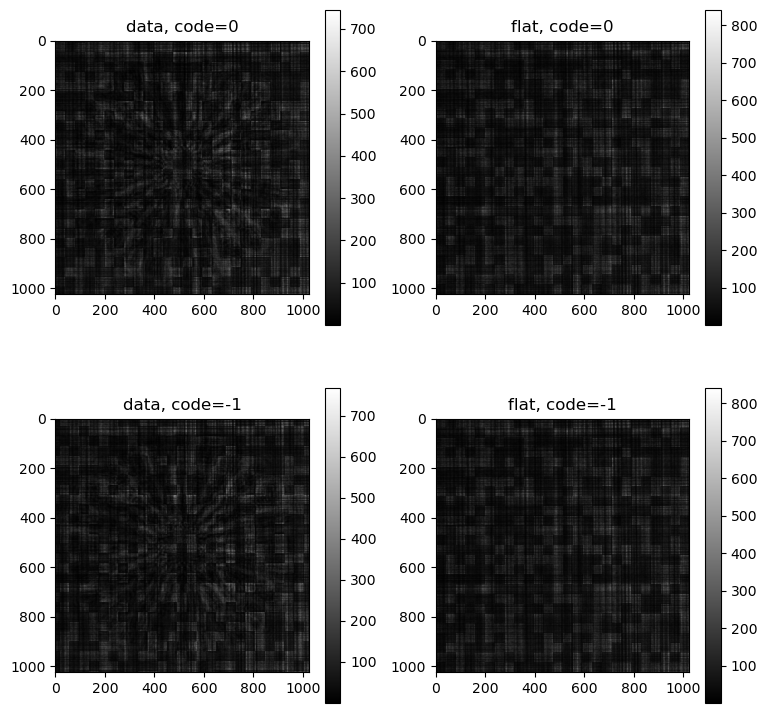

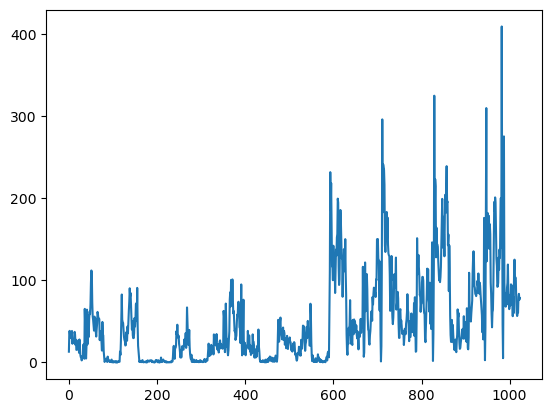

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data[0,0],cmap='gray')
axs[0,0].set_title('data, code=0')
fig.colorbar(im)
im=axs[0,1].imshow(data_ref[0,0],cmap='gray')
axs[0,1].set_title('flat, code=0')
fig.colorbar(im)
im=axs[1,0].imshow(data[-1,0],cmap='gray')
axs[1,0].set_title('data, code=-1')
fig.colorbar(im)
im=axs[1,1].imshow(data_ref[-1,0],cmap='gray')
axs[1,1].set_title('flat, code=-1')
fig.colorbar(im)
plt.figure()
plt.plot(data_ref[0,0,n//2])


# Save data and flat fields

In [34]:
for k in range(len(distances)):
    print(np.linalg.norm(data[k]))
    dxchange.write_tiff(data[k],f'data/modeling/data_siemens_codes_{n}_{k}',overwrite=True)
    dxchange.write_tiff(data_ref[0,0],f'data/modeling/ref_siemens_codes_{n}_0',overwrite=True)
dxchange.write_tiff(psi[0,0],f'data/modeling/psi_siemens_{n}_0',overwrite=True)


dxchange.write_tiff(np.abs(psiill),f'data/modeling/psiill_abs_{n}',overwrite=True)
dxchange.write_tiff(np.angle(psiill),f'data/modeling/psiill_angle_{n}',overwrite=True)

np.save('shifts',shifts)
np.save('shifts_code',shifts_code)


167313.6
167844.4
167625.61
167695.52
(4, 4, 2)
